# Inspect charter school data

- Author: Jaren Haber
- Institution: UC Berkeley
- Date created: August, 2018
- Date last edited: May 17, 2019

Description: This simple notebook reads the latest charter data into memory and offers some simple statistics. Versatile and useful basis for other tasks.

## Initialize

In [1]:
# Import packages
import pandas as pd # For working with DataFrames
import gc # To accelerate loading pickle files

# Show visualizations within notebook:
%matplotlib inline 

In [2]:
# Load functions from data_tools directory:
import sys; sys.path.insert(0, "../tools")

# For displaying basic DF info, storing DFs for memory efficiency, and loading a filtered DF:
from df_tools import check_df, convert_df, load_filtered_df, replace_df_nulls

# For quickly loading & saving pickle files in Python:
from quickpickle import quickpickle_dump, quickpickle_load 

# For saving and loading text lists to/from file:
from textlist_file import write_list, load_list 

In [5]:
# Set file paths
charters_path = "../../nowdata/charters_2015.pkl"
ccd17_path = "../../nowdata/ccd_csvs/ccd_sch_029_1718_w_0a_03302018.csv"

In [21]:
# Load, filter, and save list of names & addresses:
df = load_filtered_df(charters_path, ["SCH_NAME", "ADDRESS16", "LCITY16"])
df = df[df["SCH_NAME"].notnull() | df["ADDRESS16"].notnull()]
df.rename(inplace=True, columns={"SCH_NAME":"name", "ADDRESS16":"address", "LCITY16":"city"})
df.to_csv("/home/jovyan/work/swarm/data/names_addresses_1516.csv")

In [120]:
# Load data, keeping only relevant columns
df = load_filtered_df(
    charters_path, 
    ["WEBTEXT", "CMO_WEBTEXT", "URL", "SCH_NAME", "INQUIRY_COUNT", "INQUIRY_RATIO", 
     "NUMWORDS", "NUMPAGES", "NCESSCH", "SY_STATUS15"])

# rows and cols:  (10965, 10)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
URL: 3828 missing
SCH_NAME: 8421 missing
INQUIRY_COUNT
INQUIRY_RATIO: 4103 missing
NUMWORDS
NUMPAGES
NCESSCH
SY_STATUS15: 3619 missing
WEBTEXT
CMO_WEBTEXT


In [121]:
# Sanity check: Detect duplicates
print(len(df["NCESSCH"])) # Number of values in NCESSCH column
print(len(df["NCESSCH"])-len(df.drop_duplicates(subset="NCESSCH"))) # Method 1 to detect number of duplicates
print(len(list(df["NCESSCH"]))-len(list(set(df["NCESSCH"])))) # Method 2 to detect number of duplicates

10965
0
0


## Check number of schools without websites vs. closed

In [141]:
# Filter to only OPEN schools
filtered_OPEN = (df['SY_STATUS15'] == 1) | (df['SY_STATUS15'] == 3) | (df['SY_STATUS15'] == 4) | (df['SY_STATUS15'] == 5) | (df['SY_STATUS15'] == 8)
filtered_WEB = (df['INQUIRY_COUNT'].notnull()) & (df['NUMWORDS'] > 0.0) & (df['WEBTEXT'].apply(len) > 0)
df = df.loc[filtered_OPEN].reset_index(drop=True) # filter to only open schools
dfweb = df.loc[filtered_WEB].reset_index(drop=True) # filter to schools WITH web data
print("Lengths of open and with-web dfs: " + str(len(df)) + ", " + str(len(dfweb)))

Lengths of open and with-web dfs: 6947, 4466


In [142]:
# Filter to only OPEN schools with NO webtext
df = df.drop(columns=["WEBTEXT", "CMO_WEBTEXT"]) # Drop to prep for merge
dfweb = dfweb.drop(columns=["WEBTEXT", "CMO_WEBTEXT"]) # Drop to prep for merge
dfnoweb = pd.merge(df, dfweb, indicator=True, how='outer') # Mark schools in dfweb vs. dfopen
dfnoweb = dfnoweb[dfnoweb['_merge'] == 'left_only'] # Keep only schools WITHOUT web text
check_df(dfnoweb, "NCESSCH")

# rows and cols:  (2481, 9)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
URL: 145 missing
SCH_NAME: 1648 missing
INQUIRY_COUNT
INQUIRY_RATIO: 233 missing
NUMWORDS
NUMPAGES
NCESSCH
SY_STATUS15
_merge


In [149]:
# Load 2017-18 CCD data
df17 = load_filtered_df(ccd17_path, ["UPDATED_STATUS", "CHARTER_TEXT", "NCESSCH"])
df17.rename(columns = {"UPDATED_STATUS":"SY_STATUS17", "CHARTER_TEXT":"CHARTER17"}, index=str, inplace = True)
print(list(df17))
print("\nNumber of identified charters in 2017-18:", str(len(df17[df17["CHARTER17"]=="Yes"])))

# rows and cols:  (65508, 3)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
NCESSCH
UPDATED_STATUS: 1 missing
CHARTER_TEXT: 1 missing
['NCESSCH', 'SY_STATUS17', 'CHARTER17']

Number of identified charters in 2017-18: 5387


In [150]:
# Merge charter data with 2017-18 CCD list
df17 = pd.merge(dfnoweb, df17, how="inner", on="NCESSCH")
check_df(df17, "NCESSCH")

# rows and cols:  (1630, 11)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
URL: 21 missing
SCH_NAME: 1094 missing
INQUIRY_COUNT
INQUIRY_RATIO: 87 missing
NUMWORDS
NUMPAGES
NCESSCH
SY_STATUS15
_merge
SY_STATUS17
CHARTER17


In [152]:
# Check percentage of those schools with NO WEB TEXT that are OPEN in 2017-18 (turns out only 56 / 1630):
df17["SY_STATUS17"].value_counts()

1.0    1574
2.0      52
6.0       4
Name: SY_STATUS17, dtype: int64

## Inspect web text

In [120]:
# Load data, keeping only relevant columns
df = load_filtered_df(
    charters_path, 
    ["WEBTEXT", "CMO_WEBTEXT", "URL", "SCH_NAME", "INQUIRY_COUNT", "INQUIRY_RATIO", 
     "NUMWORDS", "NUMPAGES", "NCESSCH", "SY_STATUS15"])

# Filter to only OPEN schools
filtered_OPEN = (df['SY_STATUS15'] == 1) | (df['SY_STATUS15'] == 3) | (df['SY_STATUS15'] == 4) | (df['SY_STATUS15'] == 5) | (df['SY_STATUS15'] == 8)
df = df.loc[filtered_OPEN].reset_index(drop = True)

# rows and cols:  (10965, 10)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
URL: 3828 missing
SCH_NAME: 8421 missing
INQUIRY_COUNT
INQUIRY_RATIO: 4103 missing
NUMWORDS
NUMPAGES
NCESSCH
SY_STATUS15: 3619 missing
WEBTEXT
CMO_WEBTEXT


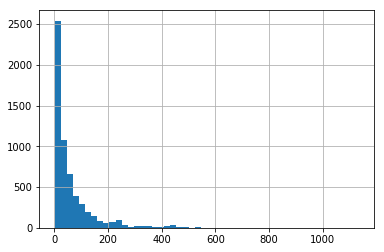

In [36]:
# Look at length of WEBTEXT cell across rows (number of pages per school)
df[df["WEBTEXT"].notnull() & df["WEBTEXT"]!=0]["WEBTEXT"].apply(len).hist(bins=50)

In [53]:
# Look at WEBTEXT and CMO_WEBTEXT for sample school:
len(df.iloc[36]["WEBTEXT"])

4

In [51]:
df.iloc[36]["WEBTEXT"][:2]

[('http://bennettacademysocial.wixsite.com/bennettacademy/copy-of-coming-soon',
  'False',
  '1',
  'ABOUT\nSCHOOLS\nPROGRAMS\nENROLL\nPARENT LINKS\nCOMMUNITY\nCONTACT\nMORE>>\nBENNETT ACADEMY ACCELERATED HIGH SCHOOL\xa0\n\u200b\nBennett Accelerated High School\xa0\nBennett Accelerated High School will begin serving students in 9th and 10th grade in August 2018. Bennett Accelerated High School will offer the followng:\xa0\n\u200b\nA good school with good discipline\nA well-organized learning environment with a friendly vibe\nA place where teachers, staff, and students treat each other kindly and respectfully\nAn environment with friends (and we add, good friends)\nTeachers who care about their students and give them good help\nCourses that teach them what they need\nCore classes and several electives\nSports\nVision and Purpose\nGrade 9 Course Descriptions\nGrade 10 Course Descriptions\nFAQ\nEnroll Now\n© 2012 by Twenty First\xa0Century\xa0\n\xa0 \xa0 \xa0Charter Schools\n\u200b\nBenne

In [52]:
df.iloc[36]["CMO_WEBTEXT"][:2]

[('http://bennettacademysocial.wixsite.com/bennettacademy',
  'False',
  '0',
  'ABOUT\nSCHOOLS\nPROGRAMS\nENROLL\nPARENT LINKS\nCOMMUNITY\nCONTACT\nMORE>>\nNow Enrolling\nSoccer Champions\nBoard Meeting\n1/5\nA Good School for Good Kids.\xa0\nPrimary School\n Kindergarten - 3rd Grade\nMiddle School\n4th-8th Grade\nÂ© 2012 by Twenty First\xa0Century\xa0\n\xa0 \xa0 \xa0Charter Schools\n\u200b\nBennett Academy Middle School\n\u200b2930 W. Bethany Home Road. Phoenix, AZ\xa085017\nBennett Academy Primary School - Venture Site\n1535 W.\xa0Dunlap Ave. Phoenix, AZ 85021\nWebmaster Login\n\ufeffPursuant to A.R.S. Â§38-431.02, Twenty First\xa0Century\xa0\nSchools, Inc. hereby states that all notices of the meetings of Bennett Academy and Bennett Venture Site will be posted at each administrative office and on our website (www.bennettacademy.com). The location is open to the public Monday through Friday from 8:00 AM to 4:00 PM. Such notices will indicate the date, time and place of the meeting a

## Check examples of high/low ideology

In [78]:
df["INQUIRY_RATIO"].describe()

count    5819.000000
mean        0.006593
std         0.005475
min         0.000000
25%         0.003228
50%         0.005400
75%         0.008641
max         0.052288
Name: INQUIRY_RATIO, dtype: float64

In [79]:
df["NUMWORDS"].describe()

count    5.819000e+03
mean     2.309760e+04
std      1.419385e+05
min      1.300000e+01
25%      1.576000e+03
50%      8.811000e+03
75%      2.186450e+04
max      7.313761e+06
Name: NUMWORDS, dtype: float64

In [94]:
# EXAMPLE OF HIGH IBL: 
# http://www.braination.net/Anne-Frank-Inspire-Academy [1]

subset = df[df["INQUIRY_RATIO"] > 0.04][df["NUMWORDS"] > 500]
print(subset["NUMPAGES"])
subset.iloc[1]["WEBTEXT"]

966     11
5852     1
6655    15
Name: NUMPAGES, dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


[('http://www.braination.net/Anne-Frank-Inspire-Academy',
  'False',
  '0',
  'nk Inspire Academy\nA Preeminent 21st Century School K–12\nHow do you make a free, public, 21st century school that is caring, creative, fun, innovative, and sustainable? How do you ensure that school retains a rigorous curriculum that pushes every student to be and do his or her best? You create an Inspire Academy!\nThe curriculum at our Inspire Academies adheres to \nstate standards\n in all subjects, including the core areas of language arts, mathematics, science, and social studies. But in order to fully address student needs, we have designed a "three tiered curriculum" that not only meets state standards but also helps students follow their passions and become self-directed learners.\xa0\nStudents explore information daily in great depth via projects, field experiences, problem solving, collaborative groups, oral and written communication, entrepreneurialism, and much more, using a skill mastery approa

In [119]:
# EXAMPLE OF LOW IBL: 
# http://bensonspvhs.sharpschool.net/ [5]
# http://rcbhighschool.com/academics/ [7]
# https://www.phoenixcollege.edu/pc-prep-academy [11]

subset = df[df["INQUIRY_RATIO"] < 0.006][df["NUMWORDS"] > 1000][df["NUMPAGES"] < 5]
print(subset["NUMPAGES"])
page = subset.iloc[5]
page["WEBTEXT"]

1       1
17      1
18      2
90      4
172     3
183     4
201     4
224     4
293     2
328     1
329     2
363     4
409     1
494     1
495     1
514     1
522     1
573     4
599     1
605     1
606     1
607     1
610     1
611     1
612     4
616     4
619     1
646     2
664     1
672     1
       ..
6314    1
6315    1
6373    2
6374    2
6406    1
6409    1
6416    1
6417    1
6418    1
6419    1
6420    1
6421    1
6422    1
6423    1
6427    1
6429    1
6430    1
6432    1
6433    1
6434    1
6439    1
6445    1
6460    1
6705    4
6725    1
6727    1
6744    1
6805    3
6809    4
6842    1
Name: NUMPAGES, Length: 196, dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


[('http://bensonspvhs.sharpschool.net/',
  'False',
  '0',
  "Benson Unified School District\nBenson Primary School\nBenson Middle School\nBenson High School\nSan Pedro Valley High School\nSan Pedro Valley Online Academy\nSearch\nSpanish\nCantonese\nFrench\nGerman\nItalian\nTagalog\nVietnamese\nKorean\nRussian\nHindi\nGuest\n | \nLogin\n\r\t\t\t{1}\t\t\t\t\r\t\t\t\n##LOC[OK]##\r\t\t\t\t\t\r\t\t\t\t\n\r\t\t\t    {1}\t\t\t\t\r\t\t\t    \n##LOC[OK]##\n##LOC[Cancel]##\n\r\t\t\t{1}\t\t\t\t\r\t\t\t\n##LOC[OK]##\n##LOC[Cancel]##\nHome\nNews\nArchived News\nStaff Directory\nMrs. Balsiger\nContact Me\nCalendar\nPhoto Gallery\nUseful Links\nContact School\nEnrollment\nFree & Reduced Meals Information & Application\nFor Parents & Students\nCalendar\nEdgenuity\nCollege Scholarships & Grants\nStudent of the Month\nStudent of the Months 2012-2013\nAugust 2012 Student of the Month\nSept. 2012 Student of the Month\nNovember 2012 Student of the Month\nDecember 2012 Student of the Month\nOctober 2012 St